<a href="https://colab.research.google.com/github/genaiconference/AgenticAI_GenAIHack/blob/main/04_agentic_rag_finance_copilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finance Copilot - LangGraph Architecture

In [ ]:
!git clone https://github.com/genaiconference/AgenticAI_GenAIHack.git

Cloning into 'AgenticAI_GenAIHack'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 171 (delta 39), reused 24 (delta 24), pack-reused 123
Receiving objects: 100% (171/171), 6.95 MiB | 10.20 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [ ]:
!pip install -r /content/AgenticAI_GenAIHack/requirements_agenti_ai.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.8/479.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.7/987.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.9/103.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

## **Import the required libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")

from simple_colors import *
from typing import Literal
from typing import List, Sequence
import numpy as np
from bs4 import BeautifulSoup
import functools, operator, requests, os, json
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage

from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langgraph.graph import StateGraph, END
from langchain.tools import tool
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
from IPython.display import Markdown

from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain_community.utilities import BingSearchAPIWrapper
from langchain.agents import Tool
from langgraph.checkpoint.sqlite import SqliteSaver

from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.output_parsers import JsonOutputParser

from AgenticAI_GenAIHack.prompts import *
from AgenticAI_GenAIHack.utils import create_MVR, create_qa_agent, create_chat_agent

#### Load environment variables

In [2]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="/content/.env")

EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_3_DEPLOYMENT_NAME')
EMBEDDING_API_KEY = os.getenv('EMBEDDING_3_API_KEY')
EMBEDDING_API_BASE = os.getenv('EMBEDDING_3_API_BASE')

GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')
GPT4_OMNI_DEPLOYMENT_NAME = os.getenv('GPT4o_DEPLOYMENT_NAME')

API_KEY = os.getenv('sweden_API_KEY')
API_BASE = os.getenv('sweden_API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

#### Define LLM and Embeddings

In [3]:
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings

llm = AzureChatOpenAI(
        azure_endpoint=API_BASE,
        openai_api_version=API_VERSION,
        azure_deployment=GPT4_OMNI_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0)

embeddings = AzureOpenAIEmbeddings(
    azure_deployment=EMBEDDING_DEPLOYMENT_NAME,
    openai_api_key=EMBEDDING_API_KEY,
    azure_endpoint=EMBEDDING_API_BASE,
    openai_api_version=API_VERSION,
)

#### Mount Google Drive to load the pre-saved vector store

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define tools for agents

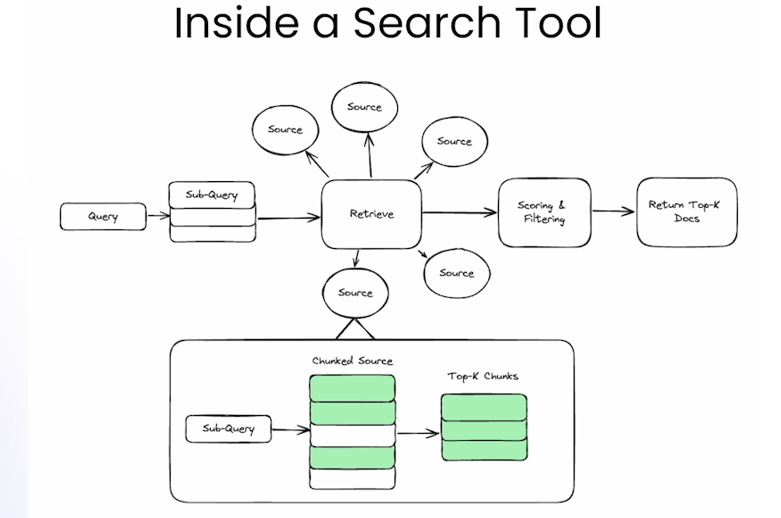

#### Create tools to retrieve the content from the private data sources

Change the below field to False to create vector store for the documents

```
vector_store_exists = False
```


In [4]:
vector_store_exists = True #

_IFRS_ret = create_MVR('IFRS.pickle', embeddings, "IFRS", vectorstore_exists=vector_store_exists, k=7)

_annual_reports_ret = create_MVR('annual_reports.pickle', embeddings, "ANNUAL_REPORTS", vectorstore_exists=vector_store_exists, k=7)

_audit_ret = create_MVR('kpmg.pickle', embeddings, "KPMG", vectorstore_exists=vector_store_exists, k=7)

In [5]:
IFRS_tool = create_retriever_tool(retriever=_IFRS_ret,
                                  name = 'IFRS_Retriever',
                                  description="Use this tool to answer questions related to IFRS which is International Financial Reporting Standards.")

ANNUAL_REPORTS_tool = create_retriever_tool(retriever = _annual_reports_ret,
                                        name = "ANNUAL_REPORTS_RETRIEVER",
                                        description = "Use this tool when you need to answer questions related to annual reports, 10K reports or 20F reports of Novartis and it's competitors ('Roche','GSK','Bayer','AstraZeneca','Sanofi', 'Amgen','Abbvie', 'BMS' - Bristol Myers Squibb, 'Gilead', 'Eli Lilly', 'Merck', 'Pfizer', 'Takeda','Johnson&Johnson', 'novo-nordisk'). If no specific year is mentioned in the question, always look for latest available year")

AUDIT_tool = create_retriever_tool(retriever=_audit_ret,
                              name = 'AUDIT_Retriever',
                              description="Use this tool to answer questions related to the Auditor(KPMG, EY, PWC) Insights on IFRS which is International Financial Reporting Standards")

#### Create general tools for internet search and processing the content extracted from Internet


In [6]:
# Create a tool to processes content from a webpage
@tool("process_content", return_direct=False)
def process_content(url: str, chunk_size: int = 10000) -> str:
    """
    Use this tool to extract content from HTML pages and chunk it recursively.

    Args:
      url (str): The URL of the HTML page to process.
      chunk_size (int, optional): The maximum size of each text chunk. Defaults to 100000.

    Returns:
      str: The chunked text content extracted from the HTML page.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser',from_encoding="iso-8859-1")
    text = soup.get_text()

    def chunk_text(text, chunk_size):
        if len(text) <= chunk_size:
            return text
        else:
            midpoint = len(text) // 2
            left_chunk = chunk_text(text[:midpoint], chunk_size)
            right_chunk = chunk_text(text[midpoint:], chunk_size)
            return left_chunk + "\n" + right_chunk

        chunks = chunk_text(text, chunk_size)
        return chunks


@tool("bing_search", return_direct=False)
def bing_search(query: str) -> str:
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    bing_search = BingSearchAPIWrapper()
    results = bing_search.results(query, 5)
    return results if results else "No results found."


# **Now Let's understand the step by step creation of a Graph**

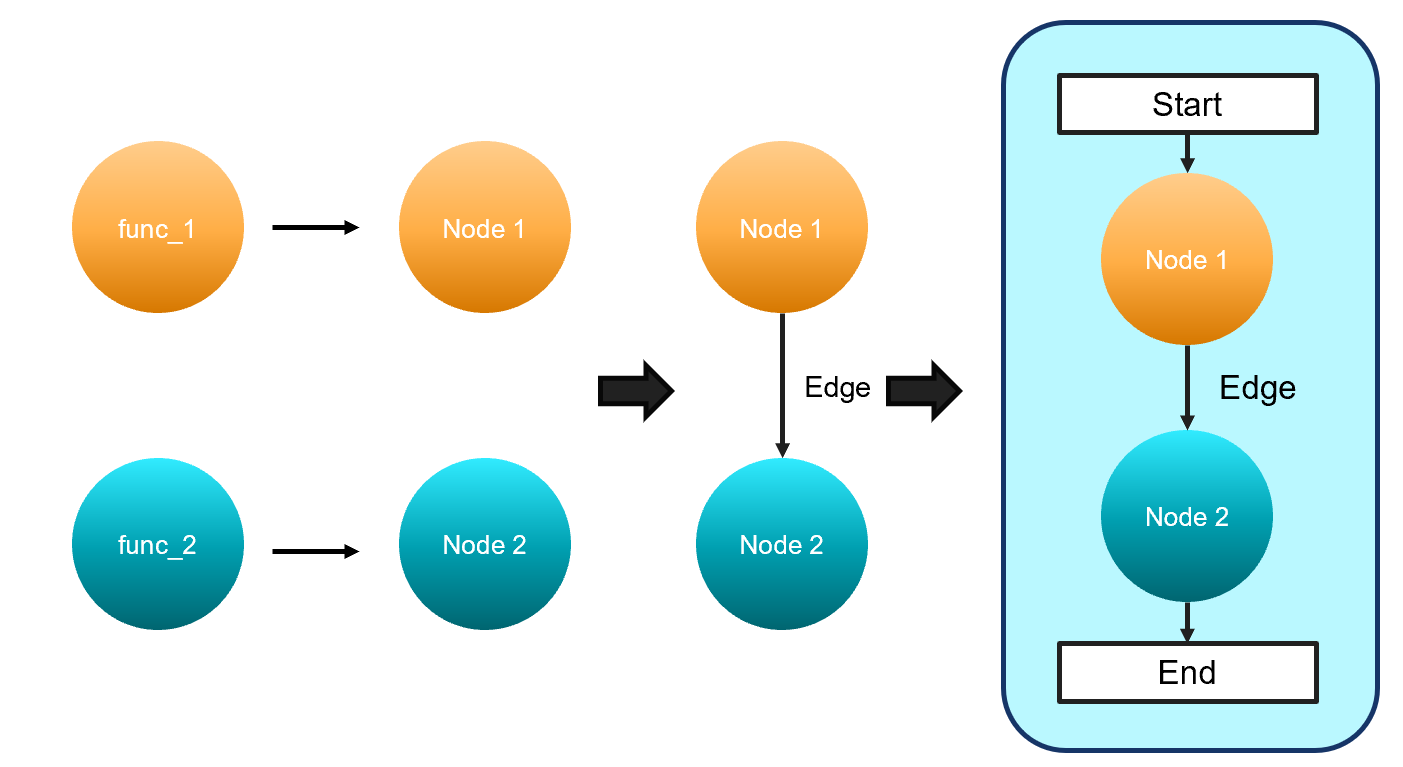

#### Define the functions to later convert them as Graph Nodes

In [7]:
class FinanceCheck_class(BaseModel):
    """Binary score for finance check on the user question."""
    binary_score: str = Field(description="Given a user question, return 'Yes' if is related to Finance/Accounting/Reporting else 'No'")


def get_finance_check(_llm, META_RESPONSE_PROMPT, state):
    parser = PydanticOutputParser(pydantic_object=FinanceCheck_class)
    prompt = PromptTemplate(template=META_RESPONSE_PROMPT,
                            input_variables=["question"],
                            partial_variables={"format_instructions": parser.get_format_instructions()},
                           )
    prompt_and_model = prompt | llm

    output = prompt_and_model.invoke({"question": question})
    result = parser.invoke(output)
    return result.binary_score


def finance_check_node(state):
    """Use this tool to check whether the user question is about finance or general greeting."""
    observation = get_finance_check(llm, META_RESPONSE_PROMPT_DETAILED, state['question'])

    print("------ENTERING: FINANCE CHECK NODE------")
    print(f"------OBSERVATION: {observation}------")

    return {"finance_check": observation}


def generic_response_node(state):
    """Use this tool to answer user generic questions"""
    print("------ENTERING: GENERIC RESPONSE NODE------")

    answer = llm.invoke(META_ANSWER_PROMPT.format(question=question))
    final_answer = answer.content
    display(Markdown(f"""<font color="black">**GENERIC RESPONSE:**</font>"""))
    display(Markdown(f"""<font color="green">{final_answer}</font>"""))
    return {"generic_response": answer, "final_answer": final_answer}


class RouteQuery_class(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["FINANCE", "WEB"] = Field(description="Given a user question choose to route it to WEB or FRA.")

def get_query_rerouter_check(llm, QUERY_REROUTER_PROMPT, state):
    parser = PydanticOutputParser(pydantic_object=RouteQuery_class)

    prompt = PromptTemplate(template=QUERY_REROUTER_PROMPT,
                            input_variables=["question"],
                            partial_variables={"format_instructions": parser.get_format_instructions()},
                           )
    prompt_and_model = prompt | llm

    output = prompt_and_model.invoke({"question": question})
    query_rerouter_check = parser.invoke(output)

    return query_rerouter_check.datasource


def query_rerouter_node(state):
    """Use this tool to check whether the user question needs an internet search to answer"""
    print("------ENTERING: QUERY REROUTER NODE------")
    observation = get_query_rerouter_check(llm, QUERY_REROUTER_PROMPT_DETAILED, state['question'])

    print(f"------OBSERVATION: {observation}------")
    return {"query_rerouter_check": observation}



def human_check_node(state):
    user_input = input("The answer is not available from the private data sources! Do you want me to search over the internet to answer?")
    return {"human_response": user_input.lower()}



def get_web_search_answer(state):
    tools = [bing_search, process_content]

    generate_prompt = """You are a web searcher trained to retrieve the current events from the internet. Search the internet for information.
                            Generate the best answer possible for the user's request with mandatory mention of the sources and the hyperlinks for the sources wherever it is possible.
                            Think step by step. Breakdown the question if it has multiple asks and finally merge your results.
                            Always crave for the best version of answer.
                            - **Always** before giving the final answer, try another method.Then reflect on the answers of the two methods you did and ask yourself if it answers correctly the original question. If you are not sure, try another method.
                            - If the methods tried do not give the same result, reflect and try again until you have two methods that have the same result.
                            - If you are sure of the correct answer, create a beautiful and thorough response.
                            ** DO NOT MAKE UP AN ANSWER OR USE YOUR PRIOR KNOWLEDGE, ONLY USE THE RESULTS OF THE CALCULATIONS YOU HAVE DONE **
                            PLEASE NOTE THAT IF NO SPECIFIC YEAR MENTIONED IN THE QUESTION, ALWAYS LOOK FOR THE LATEST YEAR.
                            """

    generate_agent = create_qa_agent(llm, tools, generate_prompt, verbose=False)
    answer = generate_agent.invoke({"input": state['question']})
    return answer['output']


def web_search_node(state):
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    print("------ENTERING: WEB SEARCH NODE------")
    ## Write code here to get answer
    response = get_web_search_answer(state)
    print(f"------WEB SEARCH ANSWER: {response}------")
    display(Markdown(f"""<font color="Black">**WEB ANSWER:**</font>"""))
    display(Markdown(f"""<font color="green">{response}</font>"""))

    return {"web_response": response, "final_answer": response}


def get_source_detector_check(llm, SOURCE_DETECTOR_PROMPT, selected_source_list, question):
    parser = JsonOutputParser()
    prompt = PromptTemplate(template=SOURCE_DETECTOR_PROMPT,
                            input_variables=["question"],
                            partial_variables={"role_based_sources": selected_source_list , "format_instructions": parser.get_format_instructions()},
                           )
    chain = prompt | llm | parser
    source_detector_check = chain.invoke({"question": question})

    return source_detector_check['Output']


def source_detector_node(state):
    """Use this tool to detect the sources needed for the question to answer"""
    print("------ENTERING: SOURCE DETECTOR NODE------")

    selected_source_list = ["ifrs_answer_node", "annual_reports_answer_node", "auditor_guidance_answer_node"]
    sources_detected = get_source_detector_check(llm, SOURCE_DETECTOR_PROMPT_DETAILED, selected_source_list, state['question'])
    print(f"------SOURCES DETECTED: {list(set(sources_detected))}------")
    return {"source_detector_check": list(set(sources_detected))}


def ifrs_answer_node(state):
    """Use this tool to answer ifrs related questions"""
    print("------ENTERING: IFRS ANSWER NODE------")

    tools = [IFRS_tool]
    generate_agent = create_qa_agent(llm, tools, IFRS_di_prompt, verbose=False)
    answer = generate_agent.invoke({"input":state['question']})
    final_answer = f"""**IFRS ANSWER:** {answer['output']} \n\n"""
    display(Markdown(f"""<font color="green">{final_answer}</font>"""))
    return {"ifrs_response": answer['output'], 'final_answer':final_answer}


def auditor_guidance_answer_node(state):
    """Use this tool to answer audit related questions"""
    print("------ENTERING: AUDITOR GUIDANCE ANSWER NODE------")
    tools = [AUDIT_tool]
    generate_agent = create_qa_agent(llm, tools, KPMG_EY_PwC_prompt, verbose=False)
    answer = generate_agent.invoke({"input":state['question']})
    final_answer = f"""**AUDITOR GUIDANCE ANSWER:** {answer['output']} \n\n"""
    display(Markdown(f"""<font color="green">{final_answer}</font>"""))
    return {"audit_response": answer['output'], 'final_answer':final_answer}


def annual_reports_answer_node(state):
    """Use this tool to answer annual reports related questions"""
    print("------ENTERING: ANNUAL REPORTS ANSWER NODE------")
    all_competitors = ['Roche','GSK','Bayer','AstraZeneca','Sanofi', 'Amgen', 'Biogen', 'Abbvie', 'BMS/Bristol Myers Squibb', 'Gilead', 'Eli Lilly', 'Merck', 'Pfizer', 'Takeda','Johnson&Johnson', 'novo-nordisk']

    competitors = ['Roche', 'Sanofi', 'Bayer', 'GSK', 'AstraZeneca']
    web_tool = bing_search

    tools = [ANNUAL_REPORTS_tool, web_tool]
    generate_agent = create_qa_agent(llm, tools, AR_prompt, verbose=False)
    answer = generate_agent.invoke({"input":state['question'], 'all_competitors':all_competitors, 'top5_competitors':competitors })
    final_answer = f"""**ANNUAL REPORTS ANSWER:** {answer['output']} \n\n"""
    display(Markdown(f"""<font color="green">{final_answer}</font>"""))
    return {"annual_reports_response": answer['output'], 'final_answer':final_answer}


def overall_status_check_node(state):
    """Use this tool to check the overall status and update the config settings"""
    print("------ENTERING: OVERALL STATUS CHECK NODE------")
    final_answer = state['final_answer']
    observation = "Completed"
    print("-------------------------------- {} --------------------------------".format(black("Final Answer", ['bold'])))
    display(Markdown(f"""**FINAL ANSWER:**\n\n <font color="green">{final_answer}</font>"""))

    return {"overall_status_check": observation, 'final_answer':final_answer}

# **Define the Graph State**

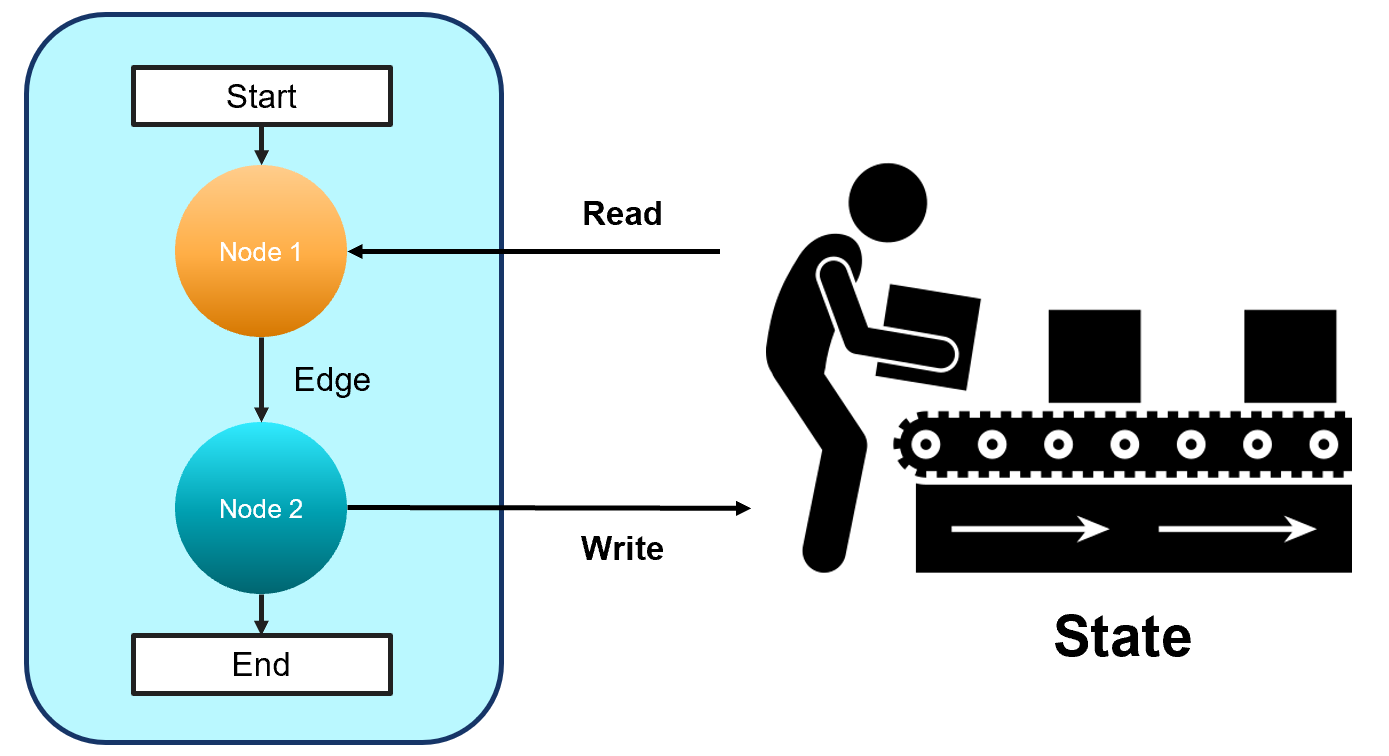

In [8]:
from typing_extensions import TypedDict
from typing import Annotated, List
import operator


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
      question: User Question

      finance_check: Whether the user question is about finance or generic question
      query_rerouter_check: Check to assess the questions needs internal private data sources or seb search to answer
      source_detector_check: Check to assess what internal private sources to be needed to answer user question
      overall_status_check: Check to assess the overall graph completion

      generic_response: Generic answer
      human_response: Human response to search over internet
      web_response: Web search response
      ifrs_response: IFRS Response
      annual_reports_response: Annual Reports Response
      audit_response: Auditor Guidance Response
      final_answer: Final Answer
    """

    question: str

    finance_check: str
    query_rerouter_check: str
    source_detector_check: List[str]
    overall_status_check: str

    generic_response: str
    human_response: str
    web_response: str
    ifrs_response: str
    annual_reports_response: str
    audit_response: str
    final_answer: Annotated[str, operator.add]

# **Now construct the Graph architecture**

### First add all the nodes to the Graph

In [19]:
from langgraph.graph import StateGraph

builder = StateGraph(GraphState)
builder.add_node("finance_check_node", finance_check_node)
builder.add_node("generic_response_node", generic_response_node)
builder.add_node("query_rerouter_node", query_rerouter_node)
builder.add_node("human_check_node", human_check_node)
builder.add_node("web_search_node", web_search_node)
builder.add_node("source_detector_node", source_detector_node)
builder.add_node("ifrs_answer_node", ifrs_answer_node)
builder.add_node("annual_reports_answer_node", annual_reports_answer_node)
builder.add_node("auditor_guidance_answer_node", auditor_guidance_answer_node)
builder.add_node("overall_status_check_node", overall_status_check_node)

### Now define the workflow

In [20]:
builder.set_entry_point("finance_check_node")

def finance_check_edge(state):
    if state["finance_check"] == "Yes":
        print("------DECISION: INVOKE QUERY REROUTER NODE------")
        return "query_rerouter_node"
    else:
        print("------DECISION: INVOKE GENERIC RESPONSE NODE------")
        return "generic_response_node"


finance_check_possible_nodes = ["query_rerouter_node", "generic_response_node"]
builder.add_conditional_edges("finance_check_node", finance_check_edge, finance_check_possible_nodes)
builder.add_edge("generic_response_node", "overall_status_check_node")


def query_rerouter_edge(state):
    if state["query_rerouter_check"] == "FINANCE":
        print("------DECISION: INVOKE SOURCE DETECTOR NODE------")
        return "source_detector_node"
    else:
        print("------DECISION: CHECK WITH USER TO INVOKE WEB SEARCH NODE------")
        return "human_check_node"


query_rerouter_possible_nodes = ["human_check_node", "source_detector_node"]
builder.add_conditional_edges("query_rerouter_node", query_rerouter_edge, query_rerouter_possible_nodes)


def human_check_edge(state):
    if state['human_response'] == "yes":
        print("------DECISION: INVOKE WEB SEARCH NODE------")
        return "web_search_node"
    else:
        print("------Your question cannot be answered due to lack of information from private data sources, please ask a different question!------")
        return "overall_status_check_node"


builder.add_conditional_edges("human_check_node", human_check_edge, ["web_search_node", "overall_status_check_node"])

builder.add_edge("web_search_node", "overall_status_check_node")


def source_detector_edge(state) -> list:
    return state["source_detector_check"]


individual_answer_nodes = ["annual_reports_answer_node", "ifrs_answer_node", "auditor_guidance_answer_node"]
builder.add_conditional_edges("source_detector_node", source_detector_edge, individual_answer_nodes)

for node in individual_answer_nodes:
    builder.add_edge(node, "overall_status_check_node")

builder.set_finish_point("overall_status_check_node")

memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

### Let's visualize the Graph

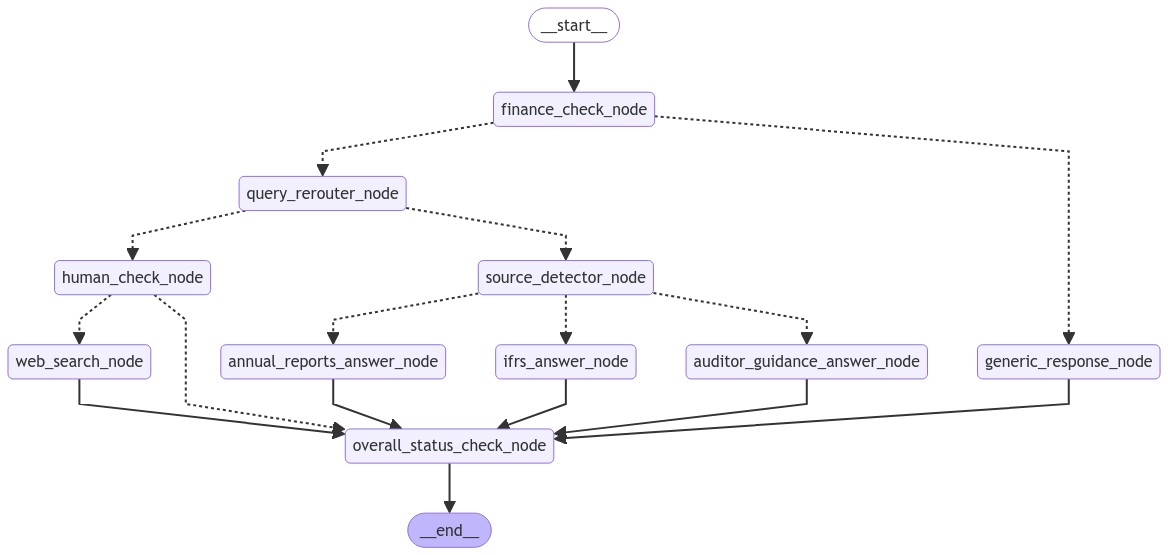

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Let's ask the questions now!

In [24]:
def run_graph(question, thread_id):
    inputs = {"question": question}
    thread = {"configurable": {"thread_id": str(thread_id)}}
    for output in graph.stream(inputs, thread, stream_mode='values'):
        pass

In [23]:
question = "Who are you?"
run_graph(question, 89)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: No------
------DECISION: INVOKE GENERIC RESPONSE NODE------
------ENTERING: GENERIC RESPONSE NODE------


<font color="black">**GENERIC RESPONSE:**</font>

<font color="green">Hello! I am Finance Copilot, your Generative AI-powered buddy here to assist you with any technical accounting or financial process-related challenges. Feel free to ask me any finance-related questions, and I'll be happy to help!</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">Hello! I am Finance Copilot, your Generative AI-powered buddy here to assist you with any technical accounting or financial process-related challenges. Feel free to ask me any finance-related questions, and I'll be happy to help!</font>

In [14]:
question = "What is the income of bayer in 2024 Q1?"
run_graph(question, 89)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: WEB------
------DECISION: CHECK WITH USER TO INVOKE WEB SEARCH NODE------
The answer is not available from the private data sources! Do you want me to search over the internet to answer?Yes
------DECISION: INVOKE WEB SEARCH NODE------
------ENTERING: WEB SEARCH NODE------
------WEB SEARCH ANSWER: The income details for Bayer in Q1 2024 are as follows:

- **Group Sales**: €13.765 billion, which represents a change of -0.6% on a currency- and portfolio-adjusted basis and -4.3% on a reported basis compared to Q1 2023.
- **EBITDA before special items**: €4.412 billion, which fell by 1.3%.

For more detailed information, you can refer to the following sources:
- [Bayer AG First Quarter 2024 Results and Media Update](https://www.bayer.com/media/en-us/bayer-ag-first-quarter-2024-results-and-media-update/)
- [Q1 2024

<font color="Black">**WEB ANSWER:**</font>

<font color="green">The income details for Bayer in Q1 2024 are as follows:

- **Group Sales**: €13.765 billion, which represents a change of -0.6% on a currency- and portfolio-adjusted basis and -4.3% on a reported basis compared to Q1 2023.
- **EBITDA before special items**: €4.412 billion, which fell by 1.3%.

For more detailed information, you can refer to the following sources:
- [Bayer AG First Quarter 2024 Results and Media Update](https://www.bayer.com/media/en-us/bayer-ag-first-quarter-2024-results-and-media-update/)
- [Q1 2024 Results | Bayer Global](https://www.bayer.com/en/investors/q1-2024-investor-video-call)
- [Bayer Quarterly Statement First Quarter 2024 - MarketScreener](https://www.marketscreener.com/quote/stock/BAYER-AG-436063/news/Bayer-Quarterly-Statement-First-Quarter-2024-46805160/)

These sources provide comprehensive insights into Bayer's financial performance for the first quarter of 2024.</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">The income details for Bayer in Q1 2024 are as follows:

- **Group Sales**: €13.765 billion, which represents a change of -0.6% on a currency- and portfolio-adjusted basis and -4.3% on a reported basis compared to Q1 2023.
- **EBITDA before special items**: €4.412 billion, which fell by 1.3%.

For more detailed information, you can refer to the following sources:
- [Bayer AG First Quarter 2024 Results and Media Update](https://www.bayer.com/media/en-us/bayer-ag-first-quarter-2024-results-and-media-update/)
- [Q1 2024 Results | Bayer Global](https://www.bayer.com/en/investors/q1-2024-investor-video-call)
- [Bayer Quarterly Statement First Quarter 2024 - MarketScreener](https://www.marketscreener.com/quote/stock/BAYER-AG-436063/news/Bayer-Quarterly-Statement-First-Quarter-2024-46805160/)

These sources provide comprehensive insights into Bayer's financial performance for the first quarter of 2024.</font>

In [15]:
question = "What is the guidance for identifying a lease as per IFRS?"
run_graph(question, 89)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FINANCE------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: SOURCE DETECTOR NODE------
------SOURCES DETECTED: ['ifrs_answer_node']------
------ENTERING: IFRS ANSWER NODE------


<font color="green">**IFRS ANSWER:** As per IFRS 16:

- **Paragraph 9**: At the inception of a contract, an entity must assess whether the contract is, or contains, a lease. A contract is, or contains, a lease if it conveys the right to control the use of an identified asset for a period of time in exchange for consideration.

- **Paragraph 10**: The period of time may be described in terms of the amount of use of an identified asset (e.g., the number of production units that an item of equipment will be used to produce).

- **Paragraph 11**: An entity should reassess whether a contract is, or contains, a lease only if the terms and conditions of the contract are changed.

- **Paragraph B9**: To determine if a contract conveys the right to control the use of an identified asset, an entity must assess whether, throughout the period of use, the customer has both:
  - The right to obtain substantially all of the economic benefits from use of the identified asset.
  - The right to direct the use of the identified asset.

- **Paragraph B13**: An asset is typically identified by being explicitly specified in a contract. However, it can also be identified implicitly at the time the asset is made available for use by the customer.

- **Paragraph B31**: A flowchart is provided to assist entities in determining whether a contract is, or contains, a lease. The key steps include:
  - Identifying if there is an identified asset.
  - Determining if the customer has the right to obtain substantially all of the economic benefits from the use of the asset.
  - Assessing if the customer has the right to direct how and for what purpose the asset is used throughout the period of use.

These guidelines help in identifying whether a contract should be accounted for as a lease under IFRS 16. 

</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">**IFRS ANSWER:** As per IFRS 16:

- **Paragraph 9**: At the inception of a contract, an entity must assess whether the contract is, or contains, a lease. A contract is, or contains, a lease if it conveys the right to control the use of an identified asset for a period of time in exchange for consideration.

- **Paragraph 10**: The period of time may be described in terms of the amount of use of an identified asset (e.g., the number of production units that an item of equipment will be used to produce).

- **Paragraph 11**: An entity should reassess whether a contract is, or contains, a lease only if the terms and conditions of the contract are changed.

- **Paragraph B9**: To determine if a contract conveys the right to control the use of an identified asset, an entity must assess whether, throughout the period of use, the customer has both:
  - The right to obtain substantially all of the economic benefits from use of the identified asset.
  - The right to direct the use of the identified asset.

- **Paragraph B13**: An asset is typically identified by being explicitly specified in a contract. However, it can also be identified implicitly at the time the asset is made available for use by the customer.

- **Paragraph B31**: A flowchart is provided to assist entities in determining whether a contract is, or contains, a lease. The key steps include:
  - Identifying if there is an identified asset.
  - Determining if the customer has the right to obtain substantially all of the economic benefits from the use of the asset.
  - Assessing if the customer has the right to direct how and for what purpose the asset is used throughout the period of use.

These guidelines help in identifying whether a contract should be accounted for as a lease under IFRS 16. 

</font>

In [16]:
question = "How do I account for Gains on sales of fixed assets?"
run_graph(question, 89)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FINANCE------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: SOURCE DETECTOR NODE------
------SOURCES DETECTED: ['ifrs_answer_node', 'annual_reports_answer_node', 'auditor_guidance_answer_node']------
------ENTERING: ANNUAL REPORTS ANSWER NODE------------ENTERING: IFRS ANSWER NODE------

------ENTERING: AUDITOR GUIDANCE ANSWER NODE------


<font color="green">**ANNUAL REPORTS ANSWER:** NO GUIDANCE 

</font>

<font color="green">**AUDITOR GUIDANCE ANSWER:** As per IAS 16:

- When an item of property, plant, and equipment is disposed of or permanently withdrawn from use, a gain or loss is recognized for the difference between any net proceeds received and the carrying amount of the asset (KPMG, page 90).
- The gain or loss on derecognition is generally included in profit or loss and is not classified as revenue (KPMG, page 90).
- The amount of consideration included in the gain or loss on derecognition and subsequent changes in that amount are estimated under the requirements for determining the transaction price in IFRS 15 (KPMG, page 90).
- In determining the net proceeds received, all directly attributable incremental costs of disposal should generally be deducted (KPMG, page 90).

Therefore, the gain on the sale of fixed assets should be calculated as follows:
1. Determine the net proceeds received from the sale.
2. Deduct the carrying amount of the asset.
3. Deduct any directly attributable incremental costs of disposal.
4. Recognize the resulting gain in profit or loss. 

</font>

<font color="green">**IFRS ANSWER:** As per IAS 16, gains on the sale of fixed assets (property, plant, and equipment) should be accounted for as follows:

- **Derecognition**: The gain or loss arising from the derecognition of an item of property, plant, and equipment should be included in profit or loss when the item is derecognized (IAS 16, paragraph 71).
- **Calculation**: The gain or loss on disposal is calculated as the difference between the net disposal proceeds and the carrying amount of the asset (IAS 16, paragraph 71).
- **Recognition**: Gains are not classified as revenue but are recognized in the profit or loss statement (IAS 16, paragraph 68).

For example, if a piece of equipment with a carrying amount of $10,000 is sold for $15,000, the gain of $5,000 ($15,000 - $10,000) should be recognized in the profit or loss statement. 

</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">**IFRS ANSWER:** As per IAS 16, gains on the sale of fixed assets (property, plant, and equipment) should be accounted for as follows:

- **Derecognition**: The gain or loss arising from the derecognition of an item of property, plant, and equipment should be included in profit or loss when the item is derecognized (IAS 16, paragraph 71).
- **Calculation**: The gain or loss on disposal is calculated as the difference between the net disposal proceeds and the carrying amount of the asset (IAS 16, paragraph 71).
- **Recognition**: Gains are not classified as revenue but are recognized in the profit or loss statement (IAS 16, paragraph 68).

For example, if a piece of equipment with a carrying amount of $10,000 is sold for $15,000, the gain of $5,000 ($15,000 - $10,000) should be recognized in the profit or loss statement. 

**ANNUAL REPORTS ANSWER:** NO GUIDANCE 

**AUDITOR GUIDANCE ANSWER:** As per IAS 16:

- When an item of property, plant, and equipment is disposed of or permanently withdrawn from use, a gain or loss is recognized for the difference between any net proceeds received and the carrying amount of the asset (KPMG, page 90).
- The gain or loss on derecognition is generally included in profit or loss and is not classified as revenue (KPMG, page 90).
- The amount of consideration included in the gain or loss on derecognition and subsequent changes in that amount are estimated under the requirements for determining the transaction price in IFRS 15 (KPMG, page 90).
- In determining the net proceeds received, all directly attributable incremental costs of disposal should generally be deducted (KPMG, page 90).

Therefore, the gain on the sale of fixed assets should be calculated as follows:
1. Determine the net proceeds received from the sale.
2. Deduct the carrying amount of the asset.
3. Deduct any directly attributable incremental costs of disposal.
4. Recognize the resulting gain in profit or loss. 

</font>

In [17]:
question = "What is the revenue trend of GSK?"
run_graph(question, 19)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FINANCE------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: SOURCE DETECTOR NODE------
------SOURCES DETECTED: ['annual_reports_answer_node']------
------ENTERING: ANNUAL REPORTS ANSWER NODE------


<font color="green">**ANNUAL REPORTS ANSWER:** ### Revenue Trend of GSK (2020-2023)

- **2020**: GSK's revenue was impacted by the COVID-19 pandemic, with expectations for Pharmaceuticals revenue to grow flat to low-single digits and Consumer Healthcare revenue to grow low to mid-single digits. Vaccines revenue was anticipated to grow flat to low-single digits due to disruptions from COVID-19 vaccination prioritization (GSK Annual Report 2020, p. 33).

- **2021**: GSK continued to focus on increasing investment in its pipeline and building on top-line momentum. The company expected a recovery in demand for its products, particularly in the second half of the year, despite initial disruptions (GSK Annual Report 2020, p. 33).

- **2022**: GSK reported a strong operational performance with good progress, demonstrating sustained performance momentum. The company focused on commercial execution and leadership development, supported by data and technology (GSK Annual Report 2022, p. 273).

- **2023**: GSK achieved total sales of £30.3 billion, reflecting a 3% increase at actual exchange rates (AER) and a 5% increase at constant exchange rates (CER). The company reported strong growth across all product areas and regions, driven by a continued step-change in commercial execution and a focus on leadership and meaningful connections with healthcare professionals and patients (GSK Annual Report 2023, Highlights).

Overall, GSK has shown a positive revenue trend from 2020 to 2023, with consistent growth and strong operational performance. 

</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">**ANNUAL REPORTS ANSWER:** ### Revenue Trend of GSK (2020-2023)

- **2020**: GSK's revenue was impacted by the COVID-19 pandemic, with expectations for Pharmaceuticals revenue to grow flat to low-single digits and Consumer Healthcare revenue to grow low to mid-single digits. Vaccines revenue was anticipated to grow flat to low-single digits due to disruptions from COVID-19 vaccination prioritization (GSK Annual Report 2020, p. 33).

- **2021**: GSK continued to focus on increasing investment in its pipeline and building on top-line momentum. The company expected a recovery in demand for its products, particularly in the second half of the year, despite initial disruptions (GSK Annual Report 2020, p. 33).

- **2022**: GSK reported a strong operational performance with good progress, demonstrating sustained performance momentum. The company focused on commercial execution and leadership development, supported by data and technology (GSK Annual Report 2022, p. 273).

- **2023**: GSK achieved total sales of £30.3 billion, reflecting a 3% increase at actual exchange rates (AER) and a 5% increase at constant exchange rates (CER). The company reported strong growth across all product areas and regions, driven by a continued step-change in commercial execution and a focus on leadership and meaningful connections with healthcare professionals and patients (GSK Annual Report 2023, Highlights).

Overall, GSK has shown a positive revenue trend from 2020 to 2023, with consistent growth and strong operational performance. 

</font>